In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime, timedelta
import re
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc

# What makes an adopted user?
This exercise asks us to identify adopted users as those who log into a service on three or more days in any given week and then determine if any features associated with users enables us to predict who will become an adopted user.

# Load data files

In [2]:
engagement_df = pd.read_csv('./takehome_user_engagement.csv')

In [3]:
users_df = pd.read_csv('./takehome_users.csv', encoding='latin-1')

In [4]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
users_df.head(15)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0


# Clean up the user file

In [6]:
users_df = users_df.drop(['name'], axis=1) 
users_df = users_df.rename({'object_id':'user_id'}, axis=1)

In [7]:
users_df.head()

,user_id,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [8]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
user_id                       12000 non-null int64
creation_time                 12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(3)
memory usage: 843.8+ KB


In [9]:
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])

In [10]:
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s')

In [11]:
users_df.head()

,user_id,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [12]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
user_id                       12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(2)
memory usage: 843.8+ KB


In [13]:
users_df['user_id'].drop_duplicates()
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
user_id                       12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(2)
memory usage: 843.8+ KB


In [14]:
users_df['email'] = users_df['email'].str.partition('@')[2]
users_df['email'] = users_df['email'].str.partition('.')[0]
users_df.head()

,user_id,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,yahoo,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,gustr,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,gustr,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,yahoo,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,yahoo,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [15]:
users_df['invited_by_user_id'] = users_df['invited_by_user_id'].fillna(0)

In [16]:
def recode(value):
    if value > 0:
        return 1
    else:
        return 0
users_df['invited_by_user_id'] = users_df.invited_by_user_id.apply(recode)

In [17]:
users_df = users_df.rename({'invited_by_user_id':'invited'}, axis=1)

In [18]:
users_df.head(20)

,user_id,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited
0,1,2014-04-22 03:53:30,yahoo,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,1
1,2,2013-11-15 03:45:04,gustr,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1
2,3,2013-03-19 23:14:52,gustr,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1
3,4,2013-05-21 08:09:28,yahoo,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,1
4,5,2013-01-17 10:14:20,yahoo,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,1
5,6,2013-12-17 03:37:06,yahoo,GUEST_INVITE,2013-12-19 03:37:06,0,0,197,1
6,7,2012-12-16 13:24:32,jourrapide,SIGNUP,2012-12-20 13:24:32,0,1,37,0
7,8,2013-07-31 05:34:02,yahoo,PERSONAL_PROJECTS,NaT,1,1,74,0
8,9,2013-11-05 04:04:24,hotmail,PERSONAL_PROJECTS,NaT,0,0,302,0
9,10,2013-01-16 22:08:03,gustr,ORG_INVITE,2014-06-03 22:08:03,1,1,318,1


# Identify adopted users

In [19]:
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [20]:
engagement_df['user_id'].drop_duplicates()
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [21]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [22]:
engagement_df = engagement_df.drop('visited', axis=1)

In [23]:
engagement_df['time_stamp'] = engagement_df['time_stamp'].astype(str)

In [24]:
engagement_df['time_stamp'] = engagement_df['time_stamp'].str.partition(' ')[0]

In [25]:
engagement_df.head()

,time_stamp,user_id
0,2014-04-22,1
1,2013-11-15,2
2,2013-11-29,2
3,2013-12-09,2
4,2013-12-25,2


In [26]:
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

In [27]:
engagement_df.drop_duplicates()
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 2 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.2 MB


In [28]:
engagement_df.head(30)

,time_stamp,user_id
0,2014-04-22,1
1,2013-11-15,2
2,2013-11-29,2
3,2013-12-09,2
4,2013-12-25,2
5,2013-12-31,2
6,2014-01-08,2
7,2014-02-03,2
8,2014-02-08,2
9,2014-02-09,2


In [29]:
aggr_df = engagement_df.groupby('user_id').count().reset_index()

In [30]:
aggr_df.head()

,user_id,time_stamp
0,1,1
1,2,14
2,3,1
3,4,1
4,5,1


In [31]:
aggr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8823 entries, 0 to 8822
Data columns (total 2 columns):
user_id       8823 non-null int64
time_stamp    8823 non-null int64
dtypes: int64(2)
memory usage: 137.9 KB


In [32]:
aggr_df.describe()

,user_id,time_stamp
count,8823.000000,8823.000000
mean,6019.821716,23.565341
std,3464.251001,73.988152
min,1.000000,1.000000
25%,3017.500000,1.000000
50%,6034.000000,1.000000
75%,9029.500000,3.000000
max,12000.000000,606.000000


In [33]:
engagement_df = engagement_df.sort_values(['user_id', 'time_stamp'], ascending=[True, True])
engagement_df.head(20)

,time_stamp,user_id
0,2014-04-22,1
1,2013-11-15,2
2,2013-11-29,2
3,2013-12-09,2
4,2013-12-25,2
5,2013-12-31,2
6,2014-01-08,2
7,2014-02-03,2
8,2014-02-08,2
9,2014-02-09,2


In [34]:
engagement_df.tail()

,time_stamp,user_id
207912,2013-09-06,11996
207913,2013-01-15,11997
207914,2014-04-27,11998
207915,2012-06-02,11999
207916,2014-01-26,12000


In [35]:
#a nested for loop to specify time spans to users takes a very long time, and maybe also itertools, 
#so I will just start with making placeholder list with just timestamps, marking those that are starts of
#sets of 3 days within a week and then apply users to these later

adopt = []
    
for idx in range(len(engagement_df)-2):
    timestampdelta = engagement_df.time_stamp[idx+2] - engagement_df.time_stamp[idx]
        
    if timestampdelta.days <= timedelta(days=7).days:
        adopt.append(1)
    else:
        adopt.append(0)


In [36]:
#for the last two, which by definition cannot start a set of 3 dates
adopt.append(0)
adopt.append(0)

In [37]:
len(adopt)

207917

In [38]:
adoptime = []
for indiv in range(len(adopt)):
    adoptime.append((engagement_df['user_id'][indiv], adopt[indiv]))

In [39]:
adoptime_df = pd.DataFrame(adoptime, columns=['user_id','adopted'])

In [40]:
adoptime_df.head(10)

,user_id,adopted
0,1,1
1,2,0
2,2,0
3,2,0
4,2,0
5,2,0
6,2,0
7,2,1
8,2,1
9,2,1


In [41]:
#to extract users with 3 or more time stamps
aggr_df = aggr_df[aggr_df['time_stamp'] >= 3]

In [42]:
#to link users to dates beginning sets of 3 days within a week
adopted_df = adoptime_df[adoptime_df['adopted'] == 1]
adopted_df.head()

,user_id,adopted
0,1,1
7,2,1
8,2,1
9,2,1
13,2,1


In [43]:
adopted_df = adopted_df.drop_duplicates()

In [44]:
#to extract users with 3+ time stamps and dates with 3 or more days in a week
adopted_df = adopted_df.merge(aggr_df, left_on='user_id', right_on='user_id')

In [45]:
adopted_df.head()

,user_id,adopted,time_stamp
0,2,1,14
1,10,1,284
2,20,1,7
3,33,1,18
4,42,1,342


In [46]:
adopted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 3 columns):
user_id       2073 non-null int64
adopted       2073 non-null int64
time_stamp    2073 non-null int64
dtypes: int64(3)
memory usage: 64.8 KB


In [47]:
adopted_df = adopted_df.drop('time_stamp', axis=1)
adopted_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 2 columns):
user_id    2073 non-null int64
adopted    2073 non-null int64
dtypes: int64(2)
memory usage: 48.6 KB


In [48]:
#before combining and fillna with 0 everywhere
#if last session is null, then fill with the same value as account creation time
users_df['last_session_creation_time'] = users_df['last_session_creation_time'].fillna(users_df['creation_time'])

In [49]:
combined_df = users_df.merge(adopted_df, left_on='user_id', right_on='user_id', how='left')
combined_df = combined_df.fillna(0)

In [50]:
combined_df.head()

,user_id,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited,adopted
0,1,2014-04-22 03:53:30,yahoo,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,1,0.0
1,2,2013-11-15 03:45:04,gustr,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1,1.0
2,3,2013-03-19 23:14:52,gustr,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1,0.0
3,4,2013-05-21 08:09:28,yahoo,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,1,0.0
4,5,2013-01-17 10:14:20,yahoo,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,1,0.0


In [51]:
combined_df.adopted = combined_df.adopted.astype(int)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 10 columns):
user_id                       12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    12000 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited                       12000 non-null int64
adopted                       12000 non-null int64
dtypes: datetime64[ns](2), int64(6), object(2)
memory usage: 1.0+ MB


# Exploratory Data Analysis

Below are shown histograms of categorical data and line plots of datetime data. May 2014 marked a very important time for activity. Below these plots are comparisons of some relationships shown in bar plots, where it appears that being invited is important to adoption. Next a plot is shown of the interval of days between last use and account creation; most service usage occurs within 100 days of account creation. Finally, a correlation heatmap is followed by chi-squared analyses of relationships among variables.

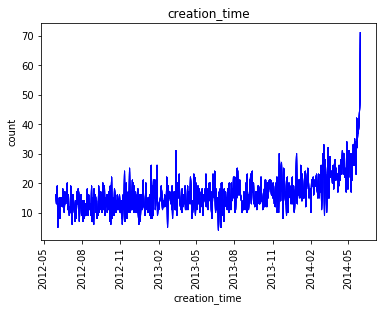

In [52]:
combined_df.groupby(combined_df['creation_time'].dt.date).count().plot(linewidth=1, color='blue', legend=None)
plt.title('creation_time')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()

In [53]:
Counter((combined_df['email']).values).most_common(10)

[('gmail', 3562),
 ('yahoo', 2447),
 ('jourrapide', 1259),
 ('cuvox', 1202),
 ('gustr', 1179),
 ('hotmail', 1165),
 ('oqpze', 2),
 ('mumdc', 2),
 ('xvnbr', 2),
 ('luque', 2)]

In [54]:
top_email_names = ['gmail', 'yahoo', 'jourrapide', 'cuvox', 'gustr', 'hotmail']
new_value = 'other'
def email_name(value):
    if value in top_email_names:
        return value
    else:
        return new_value
combined_df['email'] = combined_df['email'].apply(email_name)

Counter((combined_df['email']).values).most_common(10)

[('gmail', 3562),
 ('yahoo', 2447),
 ('jourrapide', 1259),
 ('cuvox', 1202),
 ('other', 1186),
 ('gustr', 1179),
 ('hotmail', 1165)]

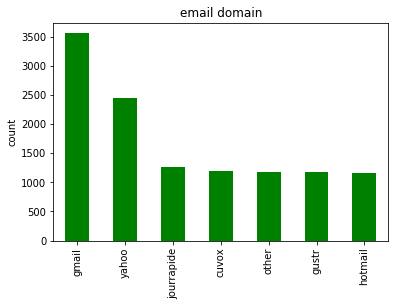

In [55]:
combined_df['email'].value_counts().plot(kind='bar', color='green')
plt.title('email domain')
plt.ylabel('count')
plt.show()

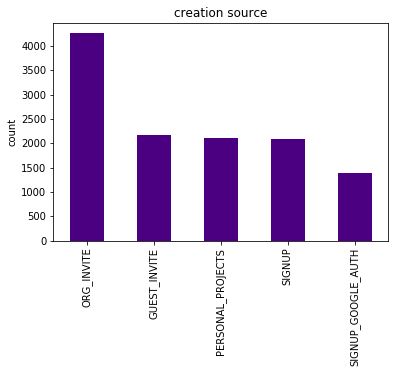

In [56]:
combined_df['creation_source'].value_counts().plot(kind='bar', color='indigo')
plt.title('creation source')
plt.ylabel('count')
plt.show()

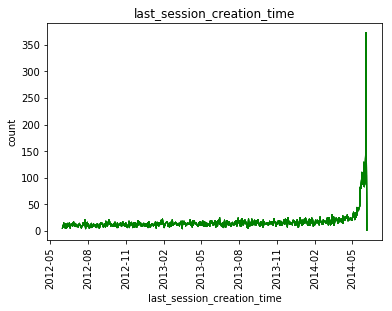

In [57]:
combined_df.groupby(combined_df['last_session_creation_time'].dt.date).count().plot(linewidth=1, color='green', legend=None)
plt.title('last_session_creation_time')
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()

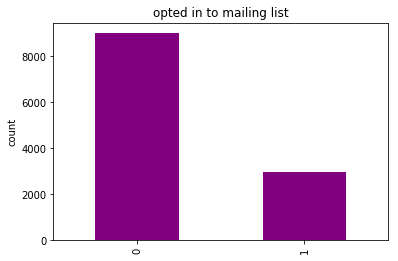

In [58]:
combined_df['opted_in_to_mailing_list'].value_counts().plot(kind='bar', color='purple')
plt.title('opted in to mailing list')
plt.ylabel('count')
plt.show()

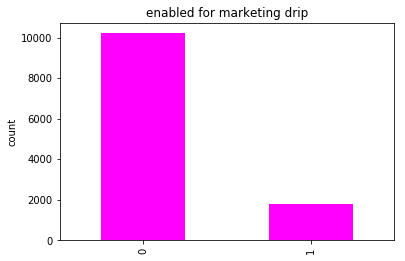

In [59]:
combined_df['enabled_for_marketing_drip'].value_counts().plot(kind='bar', color='magenta')
plt.title('enabled for marketing drip')
plt.ylabel('count')
plt.show()

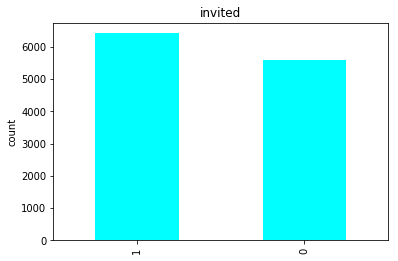

In [60]:
combined_df['invited'].value_counts().plot(kind='bar', color='aqua')
plt.title('invited')
plt.ylabel('count')
plt.show()

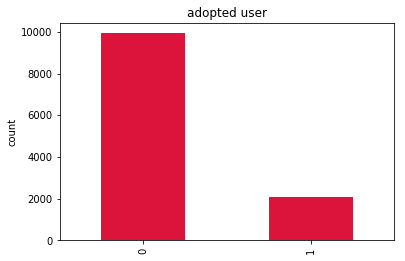

In [61]:
combined_df['adopted'].value_counts().plot(kind='bar', color='crimson')
plt.title('adopted user')
plt.ylabel('count')
plt.show()

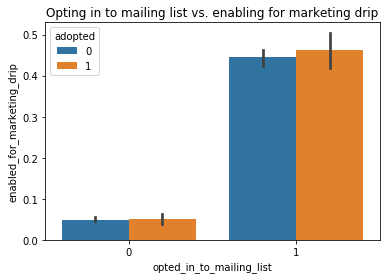

In [62]:
sns.barplot(x="opted_in_to_mailing_list", y="enabled_for_marketing_drip", hue="adopted", data=combined_df)
plt.title('Opting in to mailing list vs. enabling for marketing drip')
plt.show()

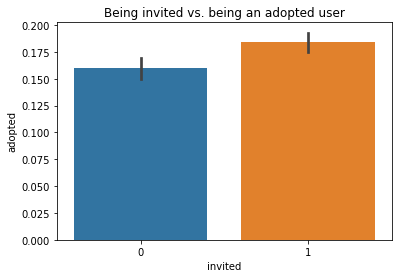

In [63]:
sns.barplot(x="invited", y="adopted", data=combined_df)
plt.title('Being invited vs. being an adopted user')
plt.show()

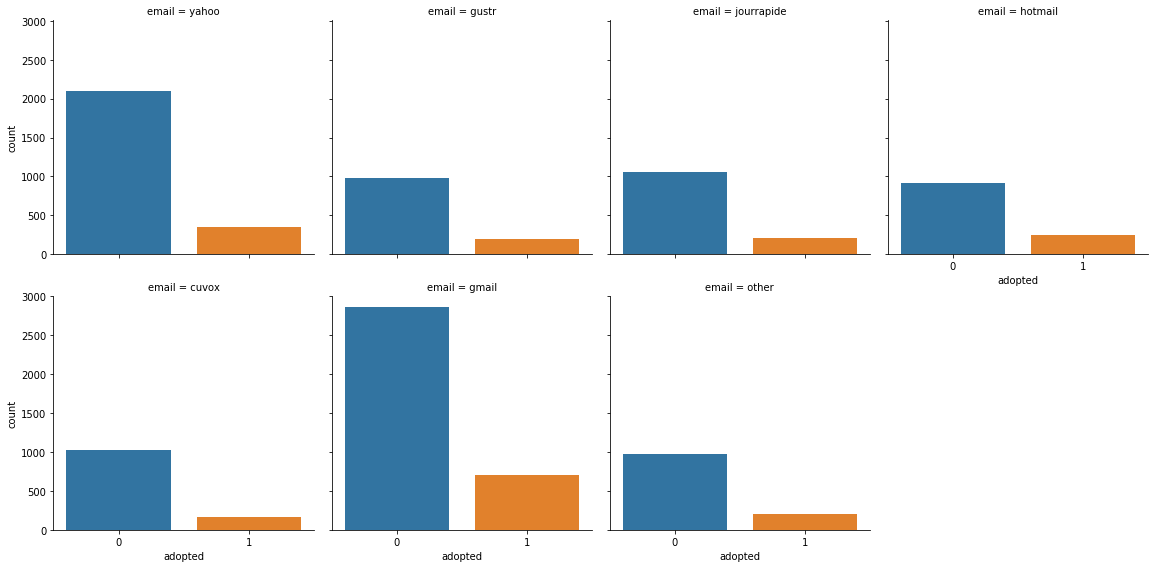

In [64]:
sns.factorplot("adopted", col="email", data=combined_df, col_wrap=4, kind="count")
plt.show()

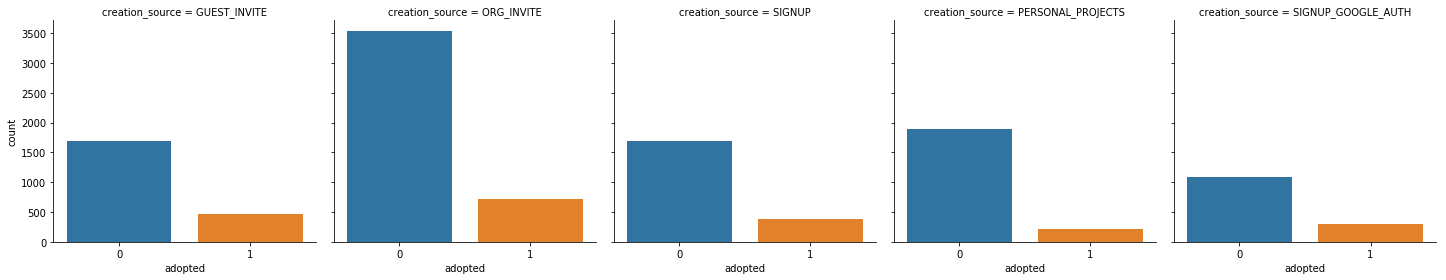

In [65]:
sns.factorplot("adopted", col="creation_source", data=combined_df, kind="count")
plt.show()

In [66]:
combined_df['days'] = np.nan

combined_df['days'] = combined_df['last_session_creation_time'] - combined_df['creation_time']
combined_df['days']=(combined_df['days'] / np.timedelta64(1, 'D'))

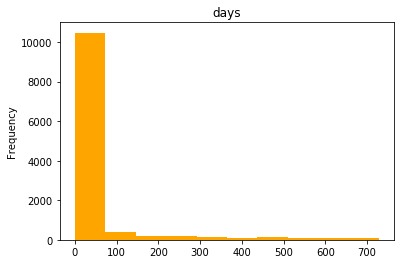

In [67]:
combined_df['days'].plot(kind='hist', color='orange')
plt.title('days')
plt.show()

In [68]:
combined_df.head()

,user_id,creation_time,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited,adopted,days
0,1,2014-04-22 03:53:30,yahoo,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,1,0,0.0
1,2,2013-11-15 03:45:04,gustr,ORG_INVITE,2014-03-31 03:45:04,0,0,1,1,1,136.0
2,3,2013-03-19 23:14:52,gustr,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1,0,0.0
3,4,2013-05-21 08:09:28,yahoo,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,1,0,1.0
4,5,2013-01-17 10:14:20,yahoo,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,1,0,5.0



Heatmap of correlations between variables


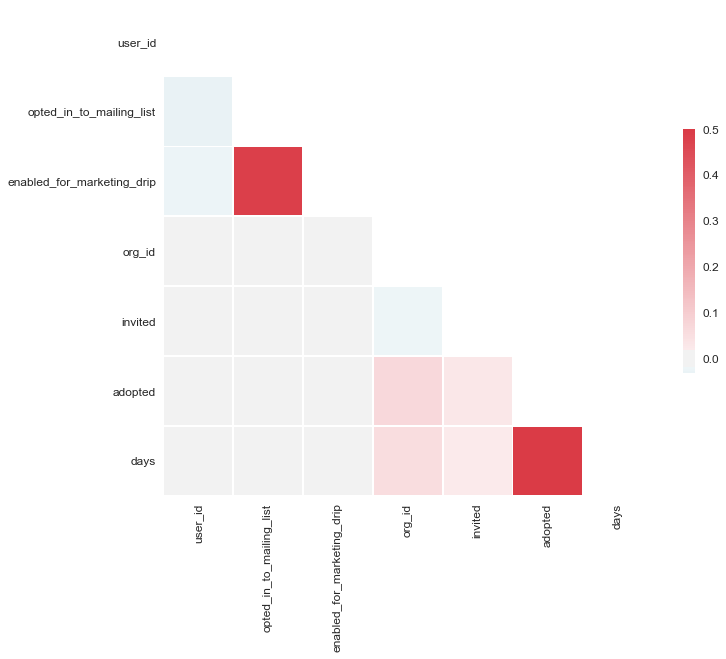

In [69]:
#adapted from code at https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white", font_scale=1.20)
corr = combined_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
# mask upper triangle by replacing values with 0 and masking zeros
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
print('\033[1m' + "\nHeatmap of correlations between variables")
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [70]:
combined_df['chi_days'] = (pd.cut(combined_df['days'], 8))

def Chi2test(colV, colZ, alpha=0.001):
    V = combined_df[colV].astype(str)
    Z = combined_df[colZ].astype(str)        
    obs = pd.crosstab(Z,V) 
    chi2, p, dof, expected = stats.chi2_contingency(obs.values)        
    Expected = pd.DataFrame(expected, columns=obs.columns, index = obs.index)
    if p<alpha:
        result="\033[1m {} with {}:".format(colV,colZ)
    else:
        result="\033[0m {} with {}:".format(colV,colZ)
    print(result, f"Chi-square stat. = {round(chi2,2)}, p = {round(p,5)}")
    
print('\033[4m\033[1m\nChi-square statistics and p-values (p) for relationships between categorical variables:\n\033[0m')  
Columns = ['email', 'creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 
           'org_id', 'invited', 'adopted', 'chi_days']
for g,h in itertools.combinations(Columns,2):
    Chi2test(g,h) 


Chi-square statistics and p-values (p) for relationships between categorical variables:

 email with creation_source: Chi-square stat. = 3725.76, p = 0.0
 email with opted_in_to_mailing_list: Chi-square stat. = 16.55, p = 0.01111
 email with enabled_for_marketing_drip: Chi-square stat. = 4.59, p = 0.59724
 email with org_id: Chi-square stat. = 2530.91, p = 0.30808
 email with invited: Chi-square stat. = 624.83, p = 0.0
 email with adopted: Chi-square stat. = 50.46, p = 0.0
 email with chi_days: Chi-square stat. = 62.49, p = 0.02171
 creation_source with opted_in_to_mailing_list: Chi-square stat. = 1.17, p = 0.88381
 creation_source with enabled_for_marketing_drip: Chi-square stat. = 0.96, p = 0.91549
 creation_source with org_id: Chi-square stat. = 1623.39, p = 0.75749
 creation_source with invited: Chi-square stat. = 12000.0, p = 0.0
 creation_source with adopted: Chi-square stat. = 123.29, p = 0.0
 creation_source with chi_days: Chi-square stat. = 109.57, p = 0.0
 opted_in_to_mailin

The correlation heatmap provides a useful visual of relationships, but value of these interpretations is limited by the fact that correlation evaluation works better for continuous variables. Most comparisons of features with each other do not show strong relationships. Email domain shows very significant chi-squared relationships with creation source, invited status, and adopted status, as well as a fairly strong relationship with opting in to mailing list. Creation source shows very strong relationships with invited and adopted statuses and with days between last session and account creation dates. Opting in to the mailing list shows a very strong relationship with enabling for marketing drip. Organization ID shows a strong relationship with adopted status and interval between last session and account creation dates. Adopted status is strongly correlated with interval between last session and account creation dates, though this is not a surprise.

In [71]:
combined_df = combined_df.drop('chi_days', axis=1)

# Predictive analytics
Next we will use machine learning to develop a model to predict adopted users. First, variables that are not likely to be useful are dropped, and dummy variables are created with categorical data to enable some classifiers to perform better. The interval "days" may be useful for examining habits of adopted users over time, but it is not useful here for predicting future users as it is an expression of longevity with the service that may be intrinsically coupled with adoption.

In [72]:
combined_df_dum = pd.get_dummies(combined_df)
combined_df_dum = combined_df_dum.drop(['user_id', 'creation_time', 'last_session_creation_time'], axis=1)
print(combined_df_dum.head())

   opted_in_to_mailing_list  enabled_for_marketing_drip  org_id  invited  \
0                         1                           0      11        1   
1                         0                           0       1        1   
2                         0                           0      94        1   
3                         0                           0       1        1   
4                         0                           0     193        1   

   adopted   days  email_cuvox  email_gmail  email_gustr  email_hotmail  \
0        0    0.0            0            0            0              0   
1        1  136.0            0            0            1              0   
2        0    0.0            0            0            1              0   
3        0    1.0            0            0            0              0   
4        0    5.0            0            0            0              0   

   email_jourrapide  email_other  email_yahoo  creation_source_GUEST_INVITE  \
0            

In [73]:
#arranged this way because I tested with and without days, which, as expected, is closely related to adopted
X = combined_df_dum.drop('adopted', axis = 1)
y = combined_df_dum.adopted
X_nodays = X.drop('days', axis = 1)

X_ND_train, X_ND_test, y_train, y_test = train_test_split(X_nodays, y, random_state=29, stratify=y)

Basic Random Forest accuracy on training data: 0.932
Basic Random Forest accuracy on test data: 0.696
             precision    recall  f1-score   support

          0       0.83      0.80      0.81      2482
          1       0.18      0.21      0.19       518

avg / total       0.72      0.70      0.71      3000

[[1979  503]
 [ 409  109]]
AUC-ROC score for Random Forest model: 0.5144


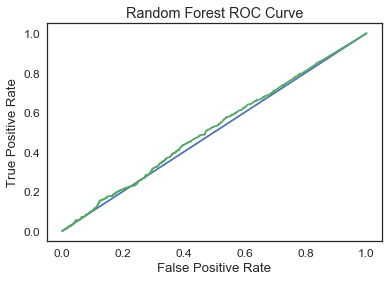

In [74]:
rfn = RandomForestClassifier(n_estimators=300, class_weight='balanced')
rfn.fit(X_ND_train, y_train)
print('Basic Random Forest accuracy on training data:',round(rfn.score(X_ND_train, y_train),3))
print('Basic Random Forest accuracy on test data:',round(rfn.score(X_ND_test, y_test),3))
rfn_pred = rfn.predict(X_ND_test)
print(classification_report(y_test,rfn_pred))
print(confusion_matrix(y_test, rfn_pred))

rny_pred_prob = rfn.predict_proba(X_ND_test)[:,1]
print('AUC-ROC score for Random Forest model:', round(roc_auc_score(y_test, rny_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, rny_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Random forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

Accuracy on training data: 0.542
Accuracy on test data: 0.533
             precision    recall  f1-score   support

          0       0.87      0.51      0.64      2482
          1       0.21      0.63      0.32       518

avg / total       0.75      0.53      0.59      3000

[[1273 1209]
 [ 193  325]]
AUC-ROC score for Logistic Regression model: 0.5958


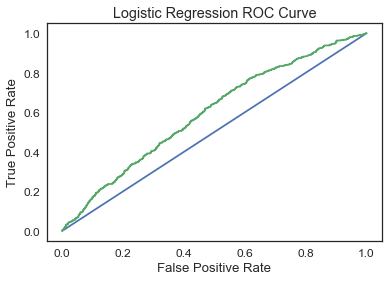

In [75]:
logrn = LogisticRegression(class_weight='balanced')
logrn.fit(X_ND_train, y_train)
lny_pred = logrn.predict(X_ND_test)
print('Accuracy on training data:',round(logrn.score(X_ND_train, y_train),3))
print('Accuracy on test data:',round(logrn.score(X_ND_test, y_test),3))
print(classification_report(y_test,lny_pred))
print(confusion_matrix(y_test,lny_pred))

lny_pred_prob = logrn.predict_proba(X_ND_test)[:,1]
print('AUC-ROC score for Logistic Regression model:', round(roc_auc_score(y_test, lny_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, lny_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [76]:
np.bincount(y_train)

array([7445, 1555])

Accuracy on training data: 0.828
Accuracy on test data: 0.827
             precision    recall  f1-score   support

          0       0.83      1.00      0.91      2482
          1       0.50      0.00      0.00       518

avg / total       0.77      0.83      0.75      3000

[[2481    1]
 [ 517    1]]
AUC-ROC score for Gradient Boost model: 0.6002


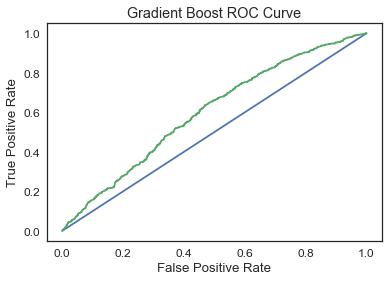

In [77]:
gbcn = GradientBoostingClassifier()
gbcn.fit(X_ND_train, y_train)
gny_pred = gbcn.predict(X_ND_test)
print('Accuracy on training data:',round(gbcn.score(X_ND_train, y_train),3))
print('Accuracy on test data:',round(gbcn.score(X_ND_test, y_test),3))
print(classification_report(y_test,gny_pred))
print(confusion_matrix(y_test,gny_pred))

gny_pred_prob = gbcn.predict_proba(X_ND_test)[:,1]
#gny_pred_prob = (gbcn.predict_proba(X_ND_test)[:,1] >= 0.173).astype(bool) 
print('AUC-ROC score for Gradient Boost model:', round(roc_auc_score(y_test, gny_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, gny_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Gradient Boost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boost ROC Curve')
plt.show()

With the remaining features examined via three classifiers, it seems difficult to predict adoption by users. The gradient boosting classifier performed the best with an AUC-ROC of 0.60, test accuracy of 0.827, and F1 score of 0.75, but accurate predictions for the target classes are highly imbalanced due to class imbalance in the data, so next we will re-examine with undersampling of the majority target class. 

In [78]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_sample(X_ND_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 1555), (1, 1555)]


Accuracy on training data: 0.653
Accuracy on test data: 0.524
             precision    recall  f1-score   support

          0       0.87      0.50      0.63      2482
          1       0.21      0.65      0.32       518

avg / total       0.76      0.52      0.58      3000

[[1236 1246]
 [ 181  337]]
AUC-ROC score for Gradient Boost model: 0.6017


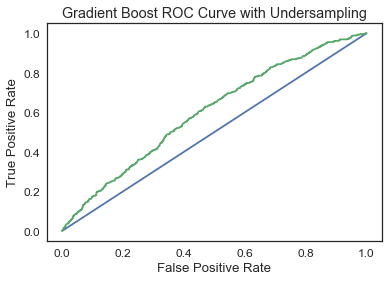

In [79]:
gbcd = GradientBoostingClassifier()
gbcd.fit(X_resampled, y_resampled)
gdy_pred = gbcd.predict(X_ND_test)
print('Accuracy on training data:',round(gbcd.score(X_resampled, y_resampled),3))
print('Accuracy on test data:',round(gbcd.score(X_ND_test, y_test),3))
print(classification_report(y_test,gdy_pred))
print(confusion_matrix(y_test,gdy_pred))

gdy_pred_prob = gbcd.predict_proba(X_ND_test)[:,1]
print('AUC-ROC score for Gradient Boost model:', round(roc_auc_score(y_test, gdy_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, gdy_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='Gradient Boost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boost ROC Curve with Undersampling')
plt.show()

While AUC-ROC stayed about the same after undersampling of the majority target class, the test accuracy and F1 scores went down a lot. Precision and recall, however, show more balance for the two target classes. Next we will look at results after tuning of hyperparameters with this classifier.

In [80]:
gbcn_params = {'learning_rate': [0.1, 0.05],'max_depth': [4, 6, 8],'min_samples_leaf': [20,50]}

CV_gbcn = GridSearchCV(estimator=gbcn, param_grid=gbcn_params, cv=5)
CV_gbcn.fit(X_ND_train, y_train)
print(CV_gbcn.best_params_)
print(CV_gbcn.best_score_)
print(CV_gbcn.best_estimator_)

{'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 50}
0.8272222222222222
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [81]:
gbcn_tuned = CV_gbcn.best_estimator_
gbcn_tuned.fit(X_ND_train, y_train)
gtny_pred = gbcn_tuned.predict(X_ND_test)
print('Accuracy on training data:',round(gbcn_tuned.score(X_ND_train, y_train),3))
print('Accuracy on test data:',round(gbcn_tuned.score(X_ND_test, y_test),3))
print(classification_report(y_test,gtny_pred))
print(confusion_matrix(y_test,gtny_pred))

gtny_pred_prob = gbcn_tuned.predict_proba(X_ND_test)[:,1]
print('AUC-ROC score for Tuned Gradient Boost model:', round(roc_auc_score(y_test, gtny_pred_prob),4))

Accuracy on training data: 0.827
Accuracy on test data: 0.827
             precision    recall  f1-score   support

          0       0.83      1.00      0.91      2482
          1       0.00      0.00      0.00       518

avg / total       0.68      0.83      0.75      3000

[[2482    0]
 [ 518    0]]
AUC-ROC score for Tuned Gradient Boost model: 0.5915


/Users/vickimoore/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Hyperparameter tuning on the full training dataset did not seem to yield a better model in terms of multiple metrics.

In [82]:
gbcd_params = {'learning_rate': [0.1, 0.05],'max_depth': [4, 6, 8],'min_samples_leaf': [20,50]}

CV_gbcd = GridSearchCV(estimator=gbcd, param_grid=gbcd_params, cv=5)
CV_gbcd.fit(X_resampled, y_resampled)
print(CV_gbcd.best_params_)
print(CV_gbcd.best_score_)
print(CV_gbcd.best_estimator_)

{'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 50}
0.5691318327974276
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)


In [83]:
gbcd_tuned = CV_gbcd.best_estimator_
gbcd_tuned.fit(X_resampled, y_resampled)
gtdy_pred = gbcd_tuned.predict(X_ND_test)
print('Accuracy on training data:',round(gbcd_tuned.score(X_resampled, y_resampled),3))
print('Accuracy on test data:',round(gbcd_tuned.score(X_ND_test, y_test),3))
print(classification_report(y_test,gtdy_pred))
print(confusion_matrix(y_test,gtdy_pred))

gtdy_pred_prob = gbcd_tuned.predict_proba(X_ND_test)[:,1]
print('AUC-ROC score for Tuned Gradient Boost model:', round(roc_auc_score(y_test, gtdy_pred_prob),4))

Accuracy on training data: 0.62
Accuracy on test data: 0.528
             precision    recall  f1-score   support

          0       0.87      0.50      0.64      2482
          1       0.21      0.64      0.32       518

avg / total       0.76      0.53      0.58      3000

[[1252 1230]
 [ 187  331]]
AUC-ROC score for Tuned Gradient Boost model: 0.5925


Likewise, with the criteria chosen, tuning of the model with undersampled target data did not improve predictive metrics, and results were similar to without tuning on with the undersampled data. Next, feature importance plots are shown with tuned data from the full dataset and the undersampled data. 

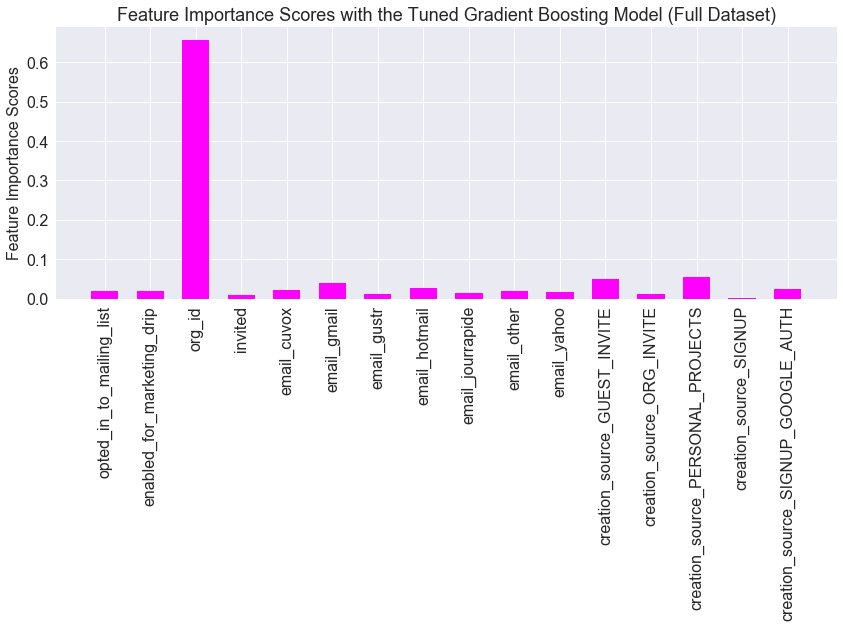

In [84]:
sns.set()
plt.figure(figsize=(14,5))
fig = gbcn.feature_importances_
nameND = X_ND_test.columns
plt.bar(np.arange(16),fig, width=0.6, color='magenta')
plt.xticks(np.arange(16),X_ND_test[1:],rotation=90, fontsize=16, label = nameND)
plt.yticks(fontsize=16)
plt.ylabel("Feature Importance Scores", fontsize=16)
plt.title('Feature Importance Scores with the Tuned Gradient Boosting Model (Full Dataset)', fontsize=18)
plt.show()

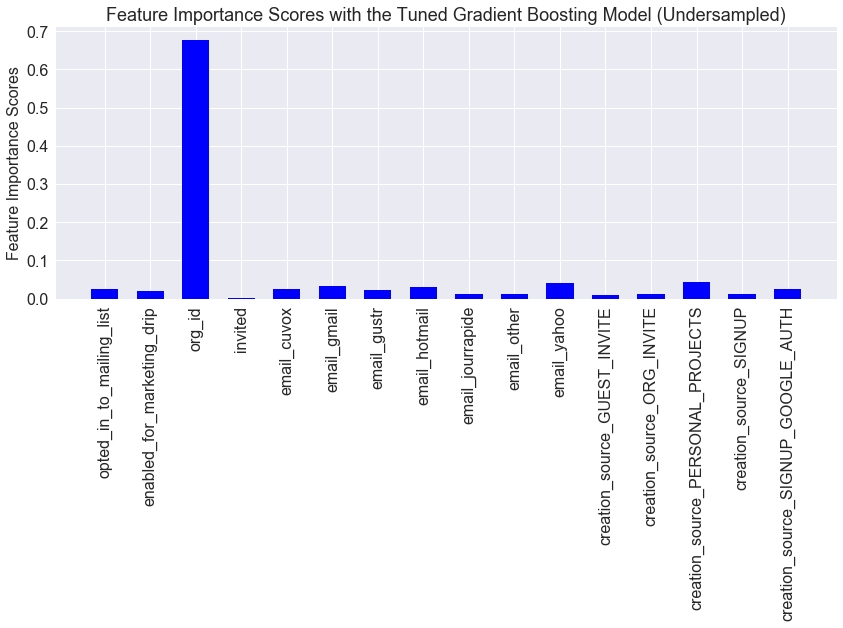

In [85]:
sns.set()
plt.figure(figsize=(14,5))
fig = gbcd.feature_importances_
nameND = X_ND_test.columns
plt.bar(np.arange(16),fig, width=0.6, color='blue')
plt.xticks(np.arange(16),X_ND_test[1:],rotation=90, fontsize=16, label = nameND)
plt.yticks(fontsize=16)
plt.ylabel("Feature Importance Scores", fontsize=16)
plt.title('Feature Importance Scores with the Tuned Gradient Boosting Model (Undersampled)', fontsize=18)
plt.show()

# Conclusion

The patterns shown in the feature importance plots indicate that organizational use of the service is strongly associated with adoption by users, as organization ID by far sweeps the list of features for predictive power here. The creation source and email domains also show some differences but to a much lesser degree. Interestingly, though invited members appeared to skew more toward adoption in the exploratory data analysis above, invited status itself seems not a strongly predictive feature. Undersampling the majority target affects relative importance of these lesser features, though the AUC-ROC was similar with or without undersampling, but with error differing for assignment to each target class.

Many of the features included here are worth inclusion in another analysis, but given how important organizational ID is, the sorts of features to explore in the future would include factors related to this. It is possible some organizations on the whole have adopted this service and not other competitor services. Examination of organization characteristics would likely be useful, and things to consider in the future may be: size of each organization, organization type, organization revenue, cost or levels of service chosen by the organization (if there are tiers), levels of interaction with the service between organizational members with each other versus people outside the organization, device types (if this is phone or computer-related), and user demographics, if available.